In [18]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from softmax import SoftmaxModel
import collections
from scipy.ndimage import gaussian_filter, convolve
import time
from dataloaders import train_dataloader, test_dataloader
from torch import nn, optim

In [23]:
TRAIN_DIR = './data/processed/train/'
TEST_DIR = './data/processed/test/'

classes = os.listdir(TRAIN_DIR)
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir(TRAIN_DIR):
    for faces in os.listdir(TRAIN_DIR+c):
        img = np.array(Image.open(TRAIN_DIR+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir(TEST_DIR):
    for faces in os.listdir(TEST_DIR+c):
        img = np.array(Image.open(TEST_DIR+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

### Models

In [19]:
class SoftMax(nn.Module):

    def __init__(self):
        super(SoftMax, self).__init__()
        self.name = "SoftMax"
        self.linear1 = nn.Linear(10304, 40)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        return x

class MLP(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(MLP, self).__init__()
        self.name = "MLP"
        self.linear1 = torch.nn.Linear(10304, 3000)
        self.linear2 = torch.nn.Linear(3000, 40)

    def forward(self,x):
        x = F.sigmoid(self.linear1(x))
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

In [27]:
def buildModel(model, lRate, plot=False, verbose=False):

    startTime = time.time()
    timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
    print("Starting at " + timeStr + " to build " + model.name + " model...")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lRate)
    train_losses, validate_losses, accuracy_data = [], [], []
    valid_loss_min = np.Inf
    
    best_accuracy = 0
    iteration_count = 0
    total_iteration = 0
    
    # as in the paper, if there is no improvment after 100 iterations
    # stop training
    while iteration_count < 100:
        total_iteration += 1
        if (total_iteration%100==0): print("epoch: " + str(total_iteration))
        running_loss = 0
        for images, labels in train_dataloader:
            output = model(images)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # epoch over
        iteration_count +=1
        
        validate_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_dataloader:
                samples = model(images)
                pred = samples.argmax(dim=1)
                accuracy = (pred == labels).sum().item() / len(labels)
                
            model.train()
            train_loss = running_loss / len(train_dataloader)
            train_losses.append(train_loss)
            accuracy_data.append(accuracy)
            
            
            if accuracy > best_accuracy:  # if we improve our accuracy, set the iteration count to 0
                if verbose:
                    print("Epoch: {}.. ".format(total_iteration))
                    print('Accuracy increased ({:.2f} --> {:.2f}). Saving model ...'.format(
                        best_accuracy, accuracy))
                torch.save(model.state_dict(), './models/'+model.name+"_model.pt")
                iteration_count = 0
                best_accuracy = accuracy  # update best accuracy

    endTime = time.time()
    dur = endTime - startTime
    timeStr = time.strftime("%H:%M:%S", time.localtime(endTime))
    print("Finished at " + timeStr + ", duration in sec: " + str(int(dur)))
    print("Total number of iterations ", total_iteration,", with accuracy of ", best_accuracy)
    return model

In [28]:
softmax = buildModel(SoftMax(), 0.1, True, True)

Starting at 08:30:03 to build SoftMax model...
Epoch: 4.. 
Accuracy increased (0.00 --> 0.40). Saving model ...
Epoch: 5.. 
Accuracy increased (0.40 --> 0.60). Saving model ...
Epoch: 9.. 
Accuracy increased (0.60 --> 1.00). Saving model ...
epoch: 100
Finished at 08:32:09, duration in sec: 125
Total number of iterations  109 , with accuracy of  1.0


### Reconstruction attack

In [51]:
# values from paper with adjusted gamma and cost function
alpha = 5000
beta = 100
gamma = 0.1
delta = 0.1

# returns a vector with all costs for all labels
def my_cost(pred):
    cost = torch.ones(pred.shape) - pred
    return cost    

In [58]:
def invert(model, img, criterion, optimizer, lr, c, best_cost, best_x, i, beta, gamma):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    
    # calculate cost
    cost = my_cost(F.softmax(pred))
    cost = cost.detach().numpy().flatten()[c]
    
    # calculate cost
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()  
    
    img = torch.clamp(img - lr * img.grad, 0, 255)
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    
    if cost < best_cost:
        print("Cost was updated, is now", cost,"was", best_cost)
        best_cost = cost
        best_x = img.detach().numpy()
    
    if cost <= best_cost and i >= beta:
        print("Cost doesn't improve after beta iterations with a value of ", cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, np_a.reshape(1, -1), True
    
    if cost <= gamma:
        print("Cost is lower than gamma with a value of ", cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, np_a.reshape(1, -1), True
    
    return best_cost, best_x, np_a.reshape(1, -1), False

<ipython-input-58-8ad75f055099>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cost = my_cost(F.softmax(pred))


Cost was update, is now 0.9745095 was 1
Cost was update, is now 0.0 was 0.9745095
Cost is lower than gamma with a value of  0.0


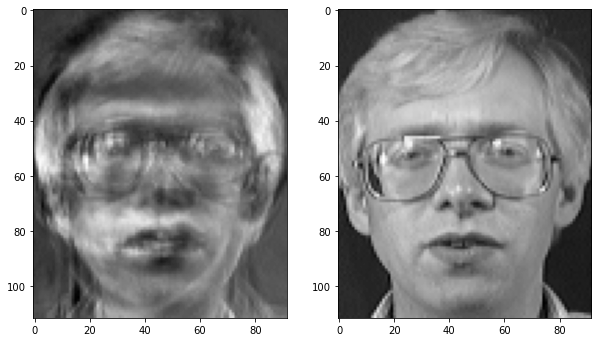

In [59]:
c = 's2'
best_x,best_cost='',1
img = np.zeros_like(train_x[0])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(softmax.parameters(), lr=delta)
for i in range(alpha):
    best_cost, best_x, img, stop = invert(softmax, img, criterion, optimizer, delta, c_to_i(c), best_cost, best_x, i, beta, gamma)
    if stop:
        break
if (c=='s2'):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(best_x.reshape(112, 92), cmap='gray')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(test_x[c_to_i(c)*3].reshape(112, 92), cmap='gray')
    plt.savefig(f'./data/results/class_{c}.png')
    plt.show()